In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

#from utils.subspace_clustering_helper_funcs import *
#from utils.ae_eval_and_vis import *
from utils.ae_torch_classes import *
from utils.LSTM_gesture_classifier import *

In [3]:
from itertools import combinations

In [4]:
import warnings
warnings.filterwarnings('ignore')
# C:\Users\kdmen\miniconda3\envs\fl_torch\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning warnings.warn(

In [5]:
print("Loading")

# Kai's laptop
#data_path = "C:\\Users\\kdmen\\Desktop\\Research\\Data\\$M\\PCA_40D\\"
#model_dir_path = 'C:\\Users\\kdmen\\Desktop\\Research\\Repos\\fl-gestures\\models\\Embedding\\Autoencoders\\'
# BRC Desktop
data_path = "D:\\Kai_MetaGestureClustering_24\\saved_datasets\\"
model_dir_path = 'C:\\Users\\YamagamiLab\\Desktop\\Dev\\fl-gestures\\models\\Embedding\\Autoencoders\\'

emg_dir = "filtered_datasets\\EMG_PPD\\"
both_dir = "filtered_datasets\\Both_PPD\\"

metadata_cols = ['Participant', 'Gesture_ID', 'Gesture_Num']
metadata_cols_df = pd.read_pickle('D:\\Kai_MetaGestureClustering_24\\saved_datasets\\metadata_cols_df.pkl')

emg_training_users_df = pd.read_pickle(data_path+emg_dir+'training_users_df.pkl').drop(metadata_cols, axis=1)
emg_test_users_df = pd.read_pickle(data_path+emg_dir+'test_users_df.pkl').drop(metadata_cols, axis=1)

both_training_users_df = pd.read_pickle(data_path+both_dir+'training_users_df.pkl').drop(metadata_cols, axis=1)
both_test_users_df = pd.read_pickle(data_path+both_dir+'test_users_df.pkl').drop(metadata_cols, axis=1)


Loading


In [6]:
num_rows_per_gesture = 64 # From the interp
batch_size = 32

## Train/test Split
> Train set:

        - Full dataset XOR all testsets
> Test sets:

        - Last 2 trials of all gestures
        - Hold out 5 users

In [7]:
combined_emg_df = pd.concat([metadata_cols_df, pd.concat([emg_training_users_df, emg_test_users_df])], axis=1)

print(combined_emg_df.shape)
combined_emg_df.head()

(204800, 19)


,Participant,Gesture_ID,Gesture_Num,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,P102,pan,1,-0.362743,-0.801651,-0.383077,-0.195299,-0.203047,-0.464472,-0.276292,-0.026736,-0.873870,-1.036152,-0.580930,-0.719494,-0.502255,-1.750091,-0.127847,-0.094192
1,P102,pan,1,-0.351553,-0.775334,-0.382545,-0.154773,-0.131977,-0.295204,-0.125822,0.089679,-0.816215,-2.082635,-0.006283,-0.139439,-0.367764,-0.208084,-0.111811,-0.039009
2,P102,pan,1,-0.380825,-0.762588,-0.398388,-0.085411,0.017528,-0.205675,-0.068451,0.117076,-0.668221,-3.403064,-0.526030,-0.478294,-0.300443,0.203266,0.113300,0.004728
3,P102,pan,1,-0.366795,-0.765464,-0.374423,-0.073225,0.183172,0.009277,-0.058907,0.080977,-0.424416,-3.709413,-0.570894,-0.775155,-0.144710,-0.619539,0.146499,0.199975
4,P102,pan,1,-0.245578,-0.761283,-0.303976,-0.081947,0.224996,0.103319,-0.003929,0.041526,-0.016530,-4.075150,-0.127710,2.682791,-0.141750,-0.208404,-0.035642,0.172662


In [8]:
unique_gestures = combined_emg_df['Gesture_ID'].unique()
unique_gestures

array(['pan', 'duplicate', 'zoom-out', 'zoom-in', 'move', 'rotate',
       'select-single', 'delete', 'close', 'open'], dtype=object)

Last 2 Trials Test Set

In [9]:
# Should I be choosing random numbers? 9 and 10 are later so may be different from earlier trials...
# Let's try 4 and 7 instead...
held_out_trials_lst = ['4', '7']

heldouttrials_testset = combined_emg_df[combined_emg_df['Gesture_Num'].isin(held_out_trials_lst)].reset_index(drop=True)

print(heldouttrials_testset.shape)
heldouttrials_testset.head()

(40960, 19)


,Participant,Gesture_ID,Gesture_Num,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,P102,pan,4,-0.549235,-0.916534,-0.525121,-0.225610,-0.333053,-0.760832,-0.375548,-0.062929,-0.920086,-2.385653,-0.381550,-0.731687,-0.268114,-0.740772,-0.129833,-0.103633
1,P102,pan,4,-0.490476,-0.890864,-0.483957,-0.225391,-0.214160,-0.579567,-0.256789,-0.087063,-0.702393,-3.445693,-0.257704,0.042039,-0.314467,-1.443360,0.066790,-0.013539
2,P102,pan,4,-0.514758,-0.890326,-0.451366,-0.185288,-0.066625,-0.421072,-0.291759,-0.034548,-0.506846,-3.134198,-0.350304,-0.132754,-0.268009,-2.053143,0.060545,0.006590
3,P102,pan,4,-0.536191,-0.864666,-0.372611,-0.103400,-0.037901,-0.213140,-0.286353,0.018436,-0.264826,-3.101445,-0.404368,4.729111,-0.164762,-0.629966,-0.092068,-0.054365
4,P102,pan,4,-0.241157,-0.623542,0.007789,-0.055446,-0.009482,-0.143867,-0.215939,0.076685,-0.147219,-3.332459,-0.486141,5.866592,-0.182525,-0.123562,0.087061,0.008114


Held Out Users Test Set

In [10]:
combined_emg_df['Participant'].unique()

array(['P102', 'P103', 'P104', 'P105', 'P106', 'P107', 'P108', 'P109',
       'P110', 'P111', 'P112', 'P114', 'P115', 'P116', 'P118', 'P119',
       'P121', 'P122', 'P123', 'P124', 'P125', 'P126', 'P127', 'P128',
       'P131', 'P132', 'P004', 'P005', 'P006', 'P008', 'P010', 'P011'],
      dtype=object)

In [11]:
held_out_users_lst = ['P104', 'P108', 'P112', 'P116', 'P122', 'P124']
heldoutusers_testset = combined_emg_df[combined_emg_df['Participant'].isin(held_out_users_lst)].reset_index(drop=True)

print(heldoutusers_testset.shape)
heldoutusers_testset.head()

(38400, 19)


,Participant,Gesture_ID,Gesture_Num,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,P104,duplicate,1,-0.836866,-0.069462,-1.201111,-3.266425,-0.143297,-0.012325,-0.246586,-0.874835,-0.903565,-0.139702,-1.199692,-1.301382,-0.065817,-0.008174,-0.002584,-0.011676
1,P104,duplicate,1,-0.780875,-0.082351,-1.208023,-3.258212,-0.110423,0.003053,-0.248364,-1.083834,-0.897283,-0.124933,-1.195211,-1.293138,0.006040,0.004724,0.019656,-0.012380
2,P104,duplicate,1,-0.830069,-0.081989,-1.250259,-3.157837,-0.129984,0.019836,-0.245799,-1.099313,-0.811197,-0.097231,-1.089515,-1.219655,-0.024191,0.015596,-0.015494,0.036700
3,P104,duplicate,1,-0.913201,-0.070693,-1.233590,-2.898543,-0.208200,0.010882,-0.219394,-1.123904,-0.798595,-0.105790,-0.904317,-1.281031,-0.068723,0.011252,-0.005082,0.080905
4,P104,duplicate,1,-0.808832,-0.066996,-1.088678,-2.514705,-0.155542,0.002881,-0.109496,-0.220264,-0.821522,-0.105144,-0.440872,-1.288635,-0.060873,-0.015651,0.004653,0.041557


Make train set now!

In [12]:
# Concatenate the smaller dataframes
combined_testsets = pd.concat([heldouttrials_testset, heldoutusers_testset]).drop_duplicates()

# Perform the anti-join
result_df = combined_emg_df.merge(combined_testsets, on=['Participant', 'Gesture_ID', 'Gesture_Num', 'EMG1', 'EMG2', 'EMG3',
                                                   'EMG4', 'EMG5', 'EMG6', 'EMG7', 'EMG8', 'EMG9', 'EMG10', 'EMG11',
                                                   'EMG12', 'EMG13', 'EMG14', 'EMG15', 'EMG16'],
                           how='left', indicator=True)
trainset = result_df[result_df['_merge'] == 'left_only'].drop(columns=['_merge'])

# Display the result
print(trainset.shape)
trainset.head()

(133120, 19)


,Participant,Gesture_ID,Gesture_Num,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,P102,pan,1,-0.362743,-0.801651,-0.383077,-0.195299,-0.203047,-0.464472,-0.276292,-0.026736,-0.873870,-1.036152,-0.580930,-0.719494,-0.502255,-1.750091,-0.127847,-0.094192
1,P102,pan,1,-0.351553,-0.775334,-0.382545,-0.154773,-0.131977,-0.295204,-0.125822,0.089679,-0.816215,-2.082635,-0.006283,-0.139439,-0.367764,-0.208084,-0.111811,-0.039009
2,P102,pan,1,-0.380825,-0.762588,-0.398388,-0.085411,0.017528,-0.205675,-0.068451,0.117076,-0.668221,-3.403064,-0.526030,-0.478294,-0.300443,0.203266,0.113300,0.004728
3,P102,pan,1,-0.366795,-0.765464,-0.374423,-0.073225,0.183172,0.009277,-0.058907,0.080977,-0.424416,-3.709413,-0.570894,-0.775155,-0.144710,-0.619539,0.146499,0.199975
4,P102,pan,1,-0.245578,-0.761283,-0.303976,-0.081947,0.224996,0.103319,-0.003929,0.041526,-0.016530,-4.075150,-0.127710,2.682791,-0.141750,-0.208404,-0.035642,0.172662


In [13]:
trainset_metadata = trainset.iloc[::num_rows_per_gesture, :3]

print(trainset_metadata.shape)
trainset_metadata.head()

(2080, 3)


,Participant,Gesture_ID,Gesture_Num
0,P102,pan,1
64,P102,pan,2
128,P102,pan,3
256,P102,pan,5
320,P102,pan,6


Encode the labels

In [14]:
# THESE ARE LABELS BY GESTURE!

label_encoder = LabelEncoder()
label_encoder.fit(unique_gestures)

# Transform the gesture labels in each dataset
train_labels = label_encoder.transform(trainset['Gesture_ID'].iloc[::num_rows_per_gesture])
testHOT_labels = label_encoder.transform(heldouttrials_testset['Gesture_ID'].iloc[::num_rows_per_gesture])
testHOU_labels = label_encoder.transform(heldoutusers_testset['Gesture_ID'].iloc[::num_rows_per_gesture])

print(f"train_labels shape: {train_labels.shape}")
print(f"testHOT_labels shape: {testHOT_labels.shape}")
print(f"testHOU_labels shape: {testHOU_labels.shape}")


train_labels shape: (2080,)
testHOT_labels shape: (640,)
testHOU_labels shape: (600,)


In [15]:
train_labels[:5]

array([5, 5, 5, 5, 5])

In [16]:
testHOT_labels[:5]

array([5, 5, 2, 2, 9])

In [17]:
testHOU_labels[:5]

array([2, 2, 2, 2, 2])

In [18]:
# CREATE THE TRAINING SET
num_train_gestures = len(trainset) // num_rows_per_gesture
num_emg_features = emg_training_users_df.shape[1]
num_HOT_gestures = len(heldouttrials_testset) // num_rows_per_gesture
num_HOU_gestures = len(heldoutusers_testset) // num_rows_per_gesture


In [19]:
X_3DTensor_full_emg = torch.tensor(trainset.iloc[:,3:].to_numpy().reshape(num_train_gestures, num_rows_per_gesture, num_emg_features), dtype=torch.float32)
Xtest_3DTensor_HOT = torch.tensor(heldouttrials_testset.iloc[:,3:].to_numpy().reshape(num_HOT_gestures, num_rows_per_gesture, num_emg_features), dtype=torch.float32)
Xtest_3DTensor_HOU = torch.tensor(heldoutusers_testset.iloc[:,3:].to_numpy().reshape(num_HOU_gestures, num_rows_per_gesture, num_emg_features), dtype=torch.float32)


In [20]:
hidden_dim_lst = [9]
input_dim = 16
RNNAE_9mir_EMGFull = RNNAutoencoder(input_dim, hidden_dim_lst, num_layers=None, seq_len=num_rows_per_gesture, progressive=False, mirror=True)
RNNAE_9mir_EMGFull.load_state_dict(torch.load(model_dir_path+'RNNAE_9mir_vallossp277_EMGFull.pth'))

<All keys matched successfully>

These are the 

In [21]:
X_emg_train_embeddings = RNNAE_9mir_EMGFull.encode(X_3DTensor_full_emg)
X_emgHOT_test_embeddings = RNNAE_9mir_EMGFull.encode(Xtest_3DTensor_HOT)
X_emgHOU_test_embeddings = RNNAE_9mir_EMGFull.encode(Xtest_3DTensor_HOU)

print(f"X_emg_train_embeddings shape: {X_emg_train_embeddings.shape}")
print(f"X_emgHOT_test_embeddings shape: {X_emgHOT_test_embeddings.shape}")
print(f"X_emgHOU_test_embeddings shape: {X_emgHOU_test_embeddings.shape}")


X_emg_train_embeddings shape: torch.Size([2080, 64, 9])
X_emgHOT_test_embeddings shape: torch.Size([640, 64, 9])
X_emgHOU_test_embeddings shape: torch.Size([600, 64, 9])


In [22]:
num_embedded_emg_features = hidden_dim_lst[-1]

So let's add the metadata to them so we can index/slice them

In [24]:
full_train_data_wmd = pd.concat([trainset_metadata, pd.DataFrame(X_emg_train_embeddings.detach().numpy())], axis=1)

print(full_train_data_wmd.shape)
full_train_data_wmd.head()

ValueError: Must pass 2-d input. shape=(2080, 64, 9)

In [28]:
## THIS IS FOR SKLEARN ALGOS (2D)

X_2Dfeatures_train_embeddings = X_emg_train_embeddings.detach().numpy().reshape(-1, num_embedded_emg_features)
X_2Dfeatures_test_HOTembeddings = X_emgHOT_test_embeddings.detach().numpy().reshape(-1, num_embedded_emg_features)
X_2Dfeatures_test_HOUembeddings = X_emgHOU_test_embeddings.detach().numpy().reshape(-1, num_embedded_emg_features)

X_2Dgestures_train_embeddings = X_emg_train_embeddings.detach().numpy().reshape(X_emg_train_embeddings.shape[0], -1)
X_2Dgestures_test_HOTembeddings = X_emgHOT_test_embeddings.detach().numpy().reshape(X_emgHOT_test_embeddings.shape[0], -1)
X_2Dgestures_test_HOUembeddings = X_emgHOU_test_embeddings.detach().numpy().reshape(X_emgHOU_test_embeddings.shape[0], -1)


In [29]:
## THIS IS FOR NEURAL NETS ONLY!

# Create TensorDataset
train_dataset = TensorDataset(X_emg_train_embeddings, torch.tensor(train_labels, dtype=torch.float32))
testHOT_dataset = TensorDataset(X_emgHOT_test_embeddings, torch.tensor(testHOT_labels, dtype=torch.float32))
testHOU_dataset = TensorDataset(X_emgHOU_test_embeddings, torch.tensor(testHOU_labels, dtype=torch.float32))

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testHOT_loader = DataLoader(testHOT_dataset, batch_size=batch_size, shuffle=False)
testHOU_loader = DataLoader(testHOU_dataset, batch_size=batch_size, shuffle=False)

In [1]:
participants = trainset_metadata['Participant']

NameError: name 'trainset_metadata' is not defined

In [ ]:
for idx, (participant1, participant2) in enumerate(combinations(participants, 2)):
    print(idx)

In [ ]:
df = full_emg_df

# Identify the unique participants
participants = df['Participant'].unique()

# Initialize a dictionary to store the distances
distances = {}

# Iterate through every pair of participants
for participant1, participant2 in combinations(participants, 2):
    print(f"Pair: ({participant1}, {participant2})")
    # Filter data for each participant
    data1 = df[df['Participant'] == participant1]
    data2 = df[df['Participant'] == participant2]
    
    # Assume both participants have the same number of gestures with the same Gesture_IDs
    gesture_ids = data1['Gesture_ID'].unique()
    #gesture_ids2 = data2['Gesture_ID'].unique()
    
    pairwise_model_accuracies_matrix = np.zeros((participants, participants))
    
    for gesture_id in gesture_ids:
        # Get all gestures with the current Gesture_ID
        gestures1 = data1[data1['Gesture_ID'] == gesture_id]
        gestures2 = data2[data2['Gesture_ID'] == gesture_id]
        
        # Split the gestures into segments of 64 rows
        num_gestures = len(gestures1) // 64
        
        for i in range(num_gestures):
            gesture1 = gestures1.iloc[i*64:(i+1)*64]
            gesture2 = gestures2.iloc[i*64:(i+1)*64]
            
            # Calculate distance between the corresponding gestures
            #distance = calculate_gesture_distance(gesture1, gesture2)
            participant_pair_distances.append(distance)
    
    # Store the average distance for the current pair of participants
    avg_distance = np.mean(participant_pair_distances)
    distances[(participant1, participant2)] = avg_distance

# Convert the distances dictionary to a dataframe for better readability
distances_df = pd.DataFrame(list(distances.items()), columns=['Participant_Pair', 'Average_Distance'])

# Print or save the distances dataframe
#print(distances_df)
# distances_df.to_csv('participant_distances.csv', index=False)  # Uncomment this line to save to a CSV file

print(distances_df.shape)
distances_df.head()

## KNN

Inspecting input data

In [30]:
HOT_embeddings_df = pd.DataFrame(X_2Dfeatures_test_HOTembeddings)
print(HOT_embeddings_df.shape)
HOT_embeddings_df.head()

(40960, 9)


,0,1,2,3,4,5,6,7,8
0,0.786254,-0.314285,0.548592,-0.816808,-0.349206,-0.096862,-0.870037,-0.017545,0.617128
1,0.667677,-0.776621,0.530686,-0.798301,-0.506102,0.090195,-0.801097,-0.381420,0.419793
2,0.790646,-0.556320,0.577633,-0.730577,-0.486140,-0.046026,-0.770046,-0.206619,0.417076
3,0.424220,-0.925910,-0.490743,-0.966248,-0.850200,0.760139,-0.190887,-0.745732,-0.518701
4,0.406536,-0.649964,-0.211890,-0.966313,-0.884521,0.844461,-0.096326,-0.839667,-0.199517


In [32]:
HOU_embeddings_df = pd.DataFrame(X_2Dfeatures_test_HOUembeddings)
print(HOU_embeddings_df.shape)
HOU_embeddings_df.head()

(38400, 9)


,0,1,2,3,4,5,6,7,8
0,0.850054,0.305075,0.577713,0.056128,0.690029,0.837680,-0.739294,0.753432,0.013486
1,0.666031,0.050514,0.658458,0.428236,0.569092,0.606557,-0.541325,0.602111,-0.428503
2,0.797168,0.197482,0.550289,0.364942,0.541060,0.553355,-0.545656,0.656612,-0.300558
3,0.722180,0.069918,0.527556,0.380040,0.533714,0.472695,-0.574345,0.623296,-0.288904
4,0.627695,-0.225081,0.534342,0.309420,0.303456,0.260559,-0.417889,0.690932,-0.077435


Inspecting labels

In [33]:
HOT_labels_df = pd.DataFrame(testHOT_2D_labels)
print(HOT_labels_df.shape)
HOT_labels_df.head()

(40960, 1)


,0
0,5
1,5
2,5
3,5
4,5


In [35]:
HOU_labels_df = pd.DataFrame(testHOU_2D_labels)
print(HOU_labels_df.shape)
HOU_labels_df.head()

(38400, 1)


,0
0,2
1,2
2,2
3,2
4,2


The below is how you are supposed to break it up (eg maintaining the structure of each gesture instead of treating each row / timestep as an independent oberservation

k=1, HOT Accuracy: 47.19%
k=1, HOG Accuracy: 0.00%
k=1, HOU Accuracy: 11.33%

k=2, HOT Accuracy: 44.38%
k=2, HOG Accuracy: 0.00%
k=2, HOU Accuracy: 12.50%

k=3, HOT Accuracy: 45.00%
k=3, HOG Accuracy: 0.00%
k=3, HOU Accuracy: 14.33%

k=4, HOT Accuracy: 43.91%
k=4, HOG Accuracy: 0.00%
k=4, HOU Accuracy: 13.00%

k=5, HOT Accuracy: 44.38%
k=5, HOG Accuracy: 0.00%
k=5, HOU Accuracy: 11.50%

k=6, HOT Accuracy: 42.50%
k=6, HOG Accuracy: 0.00%
k=6, HOU Accuracy: 12.67%

k=7, HOT Accuracy: 41.72%
k=7, HOG Accuracy: 0.00%
k=7, HOU Accuracy: 11.33%

k=8, HOT Accuracy: 41.88%
k=8, HOG Accuracy: 0.00%
k=8, HOU Accuracy: 11.33%

k=9, HOT Accuracy: 42.03%
k=9, HOG Accuracy: 0.00%
k=9, HOU Accuracy: 10.83%

k=10, HOT Accuracy: 41.09%
k=10, HOG Accuracy: 0.00%
k=10, HOU Accuracy: 11.67%

k=11, HOT Accuracy: 40.94%
k=11, HOG Accuracy: 0.00%
k=11, HOU Accuracy: 10.50%

k=12, HOT Accuracy: 41.41%
k=12, HOG Accuracy: 0.00%
k=12, HOU Accuracy: 11.17%

k=13, HOT Accuracy: 38.75%
k=13, HOG Accuracy: 0.00%
k=

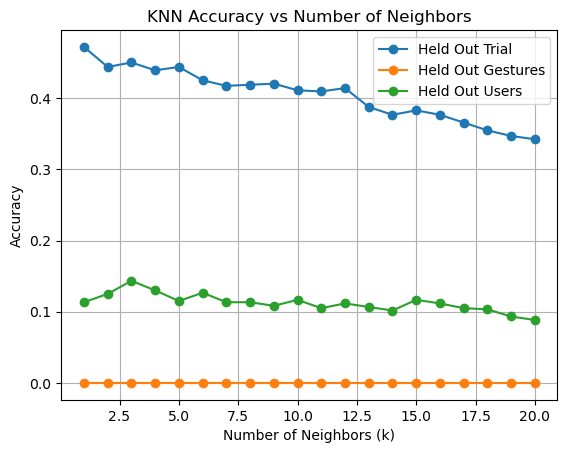

In [38]:
k_range=range(1, 21)

knn_accuraciesHOT = []
knn_accuraciesHOU = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_2Dgestures_train_embeddings, train_labels)
    
    y_pred = knn.predict(X_2Dgestures_test_HOTembeddings)
    accuracy = accuracy_score(testHOT_labels, y_pred)
    knn_accuraciesHOT.append(accuracy)
    print(f'k={k}, HOT Accuracy: {accuracy*100:.2f}%')

    y_pred = knn.predict(X_2Dgestures_test_HOUembeddings)
    accuracy = accuracy_score(testHOU_labels, y_pred)
    knn_accuraciesHOU.append(accuracy)
    print(f'k={k}, HOU Accuracy: {accuracy*100:.2f}%\n')

# Plot the accuracies for each k
plt.plot(k_range, knn_accuraciesHOT, marker='o', label='Held Out Trial')
plt.plot(k_range, knn_accuraciesHOU, marker='o', label='Held Out Users')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy vs Number of Neighbors')
plt.legend()
plt.grid(True)
plt.show()


## SVC